In [1]:
import numpy as np
import pandas as pd

from eunjeon import Mecab; mecab = Mecab()
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud

import warnings
warnings.filterwarnings(action='ignore')

### Function

In [2]:
def text_process(contents):
    file = open('./dataset/stopwords.txt', 'r', encoding='UTF8')
    STOPWORDS = file.read().split(', ')
    file.close()
    
    file = open('./dataset/gongju/min30.txt', 'r', encoding='utf-8')
    MINWORDS = file.read().split(',')
    file.close()
    
    content_list = [content for content in contents]
    
    content_text = ''.join(content_list)
    
    noun_list = mecab.nouns(content_text)
    
    noun_list = [x for x in noun_list if len(x)>=2]
    
    for i in range(len(noun_list)):
        if(noun_list[i]=='충남'):
            noun_list[i] = '충청남도'
        if(noun_list[i]=='공주'):
            noun_list[i] = '공주시'
        
    noun_list = [word for word in noun_list if word in MINWORDS]
        
    return ' '.join([word for word in noun_list if word not in STOPWORDS])

In [3]:
def todict(list_tuple):    
    todict = {}
    for i in range(0,len(list_tuple)):
        todict[list_tuple[i][0]] = list_tuple[i][1]
    return todict

In [4]:
def tolist(df):
    return [tuple(r) for r in df.to_numpy()]

In [5]:
def getRankListFromSeries(s):
    clean_list = s.to_list()

    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(clean_list)

    terms = tfidf_vectorizer.get_feature_names()

    sums = tfidf_matrix.sum(axis=0)

    data = []
    for idx, term in enumerate(terms):
           data.append( (term, sums[0, idx] ))

    ranking_df = pd.DataFrame(data, columns=['term','rank'])
    ranking_df.sort_values('rank',inplace=True, ascending=False)
    
    return tolist(ranking_df)

In [6]:
def visualize(x, xlabel, ylabel, figsize=(12,6), flag=False, bent=3, minlimit=0.003, 
              maxlimit=0.003, order=0, filename="visualize", filedir="",isSave=False, fontsize=14):
    from matplotlib import pyplot
    from scipy.signal import savgol_filter
    import matplotlib.ticker as mticker 

    pyplot.figure(figsize=figsize)
    
    pyplot.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))
    pyplot.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.3f'))

    pyplot.rcParams['font.family'] = 'Malgun Gothic'
    pyplot.rcParams['axes.unicode_minus'] =False
    pyplot.rcParams['font.size'] = 15
    pyplot.rcParams["legend.framealpha"] = 0.7
    
    pyplot.rc('font', size=fontsize)        # 기본 폰트 크기
    pyplot.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
    pyplot.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
    pyplot.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
    pyplot.rc('legend', fontsize=20)  # 범례 폰트 크기
    
    pyplot.ylabel('Probability')
    
    if flag:
        for e in range(len(ylabel)):
            xfilter = savgol_filter(x[e], len(x[e]), bent)
            xfilter[xfilter<0] = 0
            pyplot.plot(xfilter, label=ylabel[e], linewidth=4)
        
        #pyplot.legend(title='Words', loc='upper left', shadow=True, bbox_to_anchor=(1.05, 1))
        pyplot.legend(loc="upper left", ncol=3, fontsize=fontsize)        
        
    else:
        for e in range(n_topics):
            xfilter = savgol_filter(x[e], len(x[e]), bent)
            xfilter[xfilter<0] = 0
            pyplot.plot(xfilter, label=ylabel[e], linewidth=4)
        
        #pyplot.legend(title='Topics', loc='upper left', shadow=True, bbox_to_anchor=(1.05, 1))
        pyplot.legend(loc='upper left', ncol=3, fontsize=fontsize)

    pyplot.xlim(0, len(time_slice)-1)
    pyplot.ylim(min(map(min, x)) - minlimit, max(map(max, x)) + maxlimit)

    x = list(range(0, len(xlabel)))
    pyplot.xticks(x, xlabel)
    
    #pyplot.tight_layout()
    pyplot.grid()   
    
    if isSave:
        pyplot.savefig(filedir + filename + '.svg')
 
    pyplot.show()

In [7]:
def insert_row(idx, df, df_insert):
    idx = idx-2004
    return df.iloc[:idx, ].append(df_insert).append(df.iloc[idx:, ]).reset_index(drop = True)

In [8]:
def createFolder(directory):
    import os
    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

------------------------------------------------------------------------

### Load Dataset

In [9]:
model_file_name = "gongju_model"
city_name = "gongju"
dataset_path = "./dataset/" + city_name + "/naverview_" + city_name + ".xlsx"
image_path = "./dataset/" + city_name + "/image/" + model_file_name + "/"
topic_path = "./dataset/" + city_name + "/topic/"
#createFolder(image_path)

In [10]:
data_df = pd.read_excel(dataset_path, engine="openpyxl")
data_df.head()

,title,nickname,datetime,content
0,유구한 세월의 발자취 - 공주시 유구터미널,모리노\n(goyasoul88),2008. 10. 1. 2:19,석남리\n충청남도 > 공주시 > 유구읍\n기간 2008.9.21 ~ 2008.9.2...
1,공주시 ‘꿈의 교회’ 프로젝트 지역사회 감동 줘,오동균\n(odk1956),2006. 3. 21. 22:59,공주시 ‘꿈의 교회’ 프로젝트 지역사회 감동 줘\n 함께하면 풍성해지는 40일 캠...
2,공주시 산림박물관 견학,하이데스\n(pygmalion999),2007. 12. 27. 15:06,산림박물관이 있는줄 얼마전에 알았다..\n어떤것이 전시되어 있는지 궁금하기도 하...
3,찬란한 백제문화를 꽃피운 공주시가와 금강줄기가 산아래 내려다 보이는,청람\n(khrnice),2006. 9. 11. 21:16,이제 완연한 가을 날씨다..\n좀처럼 한 곳에 머물기를 죽도록 싫어하는 성격이 이렇...
4,충남 기도터-충남 공주시 사곡면 벽계산 약수암 기도터,찬누리\n(jinsug9339),2007. 3. 7. 20:54,충남 공주시 사곡면 벽계산 약수암 기도터\n(위)-벽계산 약수암 기도터 주차장과 요...


### Cleansing

In [11]:
data_df['title'] = data_df['title'].astype('str')
data_df['content'] = data_df['content'].astype('str')

In [12]:
data_df['clean_title'] = data_df.title.apply(text_process)
data_df['clean_datetime'] = data_df['datetime'].str[:4]
data_df['clean_content'] = data_df['clean_title'] + " " + data_df.content.apply(text_process)

In [13]:
data_df = data_df.sort_values(by=['clean_datetime'], axis=0)

In [14]:
idx = data_df[data_df['clean_datetime'].str.find("시간") != -1].index
data_df = data_df.drop(idx)

In [15]:
# 2004 ~ 2020
data_df = data_df[data_df['clean_datetime'] != '2003']
data_df = data_df[data_df['clean_datetime'] != '2021']

In [16]:
data_df.head()

,title,nickname,datetime,content,clean_title,clean_datetime,clean_content
3355,신행정수도 입지 8월 확정 오송ㆍ장기 유력,emerald755,2004. 5. 24. 9:58,신행정수도 입지 8월 확정 오송ㆍ장기 유력\n 신행정수도 건설추...,행정 수도 입지 확정 오송 유력,2004,행정 수도 입지 확정 오송 유력 행정 수도 입지 확정 오송 유력 신행 정수 건설 위...
3700,전국 매매·전세가 하락세 계속,자작나무\n(speed9758),2004. 10. 9. 21:33,전국 매매·전세가 하락세 계속\n [노컷뉴스 2004-10-09]\n\n 집...,매매 전세 하락세,2004,매매 전세 하락세 매매 전세 하락세 집값 집값 하락세 지속 국민은행 발표 지난달 주...
3701,행정수도 후보 4곳 선정,12345\n(hj84382000),2004. 6. 16. 12:32,"행정수도 후보 4곳 선정\n공주 연기, 논산 계룡, 천안, 진천 음성\n2004년0...",행정 수도 후보 선정,2004,행정 수도 후보 선정 행정 수도 후보 선정 공주시 연기 논산 계룡 천안 진천 음성 ...
3702,행정수도논란,덕 상\n(okchoi9),2004. 10. 28. 10:58,뉴스홈 > 핫이슈·토론 > 가장 많이 본 뉴스 > 포토\n들불처럼 번지는 행정수도 ...,행정 수도 논란,2004,행정 수도 논란 뉴스 토론 뉴스 포토 행정 수도 위헌 판결 항의 오마이 뉴스 오마이...
3703,공주·연기·계룡 '투기과열지구 지정',부쉬맨\n(bushman70),2004. 7. 30. 0:30,공주·연기·계룡 '투기과열지구 지정'\n \n[한겨레 2004-07-29 18:28...,공주시 연기 계룡 투기 과열 지구 지정,2004,공주시 연기 계룡 투기 과열 지구 지정 공주시 연기 계룡 투기 과열 지구 지정 행정...


### Load model

In [17]:
from gensim.models import LdaSeqModel
from gensim import corpora
import gensim
from tqdm import tqdm
from gensim.test.utils import datapath

In [18]:
temp_file = datapath(model_file_name)
ldaseq = LdaSeqModel.load(temp_file)

In [19]:
n_terms = 100
n_topics=len(ldaseq.print_topics(top_terms=n_terms))-1
time_slice = list(data_df.groupby('clean_datetime').count()['title'].values) 
year_list = [year for year in range(2004, 2021)]

### Generate Topic Dataframe

In [20]:
topic_df = pd.DataFrame(columns=['단어', '토픽', '연도', '단어수', '연도내총단어수', '토픽영향력', '단어비율'])

for y in tqdm(range(len(time_slice))): # 연도
    topics_list = ldaseq.print_topics(time=y, top_terms=n_terms)
    
    text_list = data_df[data_df['clean_datetime']==str(2004+y)]['clean_content'].values
    term_list = ' '.join(text_list).split(" ")
    
    for i in range(n_topics): # 토픽의 수
        for j in range(n_terms): # 한 토픽 내 총 단어 수
            word = topics_list[i][j][0] # 단어
            if len(word)==0: continue # 단어가 비었으면 넘어가기
            topic = i+1 # 토픽
            year = 2004+y  # 연도            
            numword = term_list.count(word) # 단어수
            totalword = len(term_list) # 연도내총단어수
            impact = topics_list[i][j][1] # 토픽영향력
            wordratio = numword/totalword # 단어비율 (단어수/연도내총단어수)
            topic_df.loc[len(topic_df)] = [word, topic, year, numword, totalword, impact, wordratio]

#topic_df.to_excel(topic_path + model_file_name + "_topic.xlsx")
topic_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:19<00:00,  1.15s/it]


,단어,토픽,연도,단어수,연도내총단어수,토픽영향력,단어비율
0,공주시,1,2004,2063,234522,0.017053,0.008797
1,시대,1,2004,444,234522,0.016925,0.001893
2,백제,1,2004,423,234522,0.013131,0.001804
3,국보,1,2004,337,234522,0.010933,0.001437
4,조선,1,2004,291,234522,0.010447,0.001241


In [21]:
# Calculate the proportion of words.
wordRtInYrs_list = []
for y in range(len(time_slice)):
    text_list = data_df[data_df['clean_datetime']==str(2004+y)]['clean_content'].values
    term_list = ' '.join(text_list).split(" ") # ['aaa', 'bbb', 'ccc', 'ddd', 'eee', 'fff']

    tmp_list = []
    for i in range(n_topics):
        word_list = list(set(topic_df[topic_df['토픽'] == (i+1)]['단어'].values))
        tmp_list.append(sum([term_list.count(i) for i in word_list]) / len(term_list)) # i+1번 토픽 내 단어들이 2004+y년도 게시글 단어 목록에서 몇개나 되는지 비율
    wordRtInYrs_list.append(tmp_list)

wordRtInYrs_list = np.array(wordRtInYrs_list).T

In [23]:
wordRtInYrs_array = np.array(wordRtInYrs_list)

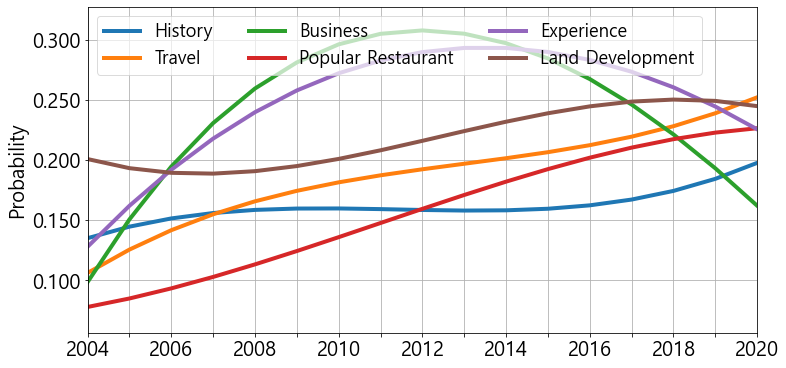

In [27]:
xlabel = ['2004', '', '2006','', '2008','', '2010','', '2012','', '2014','', '2016','', '2018','', '2020']
ylabel = ['History', 'Travel', 'Business', 'Popular Restaurant', 'Experience', 'Land Development']

visualize(wordRtInYrs_array, xlabel, ylabel, minlimit=0.02, maxlimit=-0.02, 
          bent=3, isSave=True, filename="topic", filedir=image_path, fontsize=18)

In [35]:
import collections

word_list = []
word_score = []
for i in range(n_topics):
    word_in_topic_list = topic_df[topic_df['토픽'] == (i+1)]['단어'].values
    counts = collections.Counter(word_in_topic_list)
    counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
    
    tfidf_list = getRankListFromSeries(data_df['clean_content'])[:100]
    tfidf_word_list = [word[0] for word in tfidf_list]
    
    word_remove_list = ['공주시', '충청남도']
    
    word_in_topic_list = [word[0] for word in counts if word[0] not in word_remove_list][:100]
    word_in_topic_list = [word for word in word_in_topic_list if word in tfidf_word_list]
    word_in_topic_list = word_in_topic_list[:10]
    
    for j in range(len(word_in_topic_list)):
        tmp_topic_df = topic_df[(topic_df['단어'] == word_in_topic_list[j]) & (topic_df['토픽'] == (i+1))]

        no_year_list = [year for year in year_list if year not in tmp_topic_df['연도'].values]

        tmp_list = tmp_topic_df.iloc[0]
        tmp_list[3] = 0
        tmp_list[4] = 0
        tmp_list[5] = 0
        tmp_list[6] = 0

        for year in no_year_list:
            tmp_list[2] = year
            tmp_topic_df = insert_row(year, tmp_topic_df, tmp_list)

        word_score.append(list(tmp_topic_df['토픽영향력'].values))
    word_list.append(word_in_topic_list)

In [41]:
eng_word_list = [['Era', 'Baekje', 'Culture', 'History', 'Magoksa temple', 'Museum', 'Gapsa temple', 'Gongsanseong fortress','Location', 'Korea'],
                 ['Gyeryongsan mountain', 'Park', 'Donghaksa temple', 'Gapsa temple', 'Nature', 'Daejeon', 'Road', 'Travel', 'Utilization', 'Village'],
                 ['City councilor', 'Society', 'Welfare', 'Business', 'Resident', 'Journalist', 'Citizen', 'Activity', 'Plan', 'Environment'],
                 ['Restaurant', 'Price', 'Use', 'Health', 'Photo', 'Daejeon', 'Popular restaurant', 'Family', 'Utilization', 'Location'],
                 ['Museum', 'Tourism', 'Culture', 'Korea', 'Festival', 'Education', 'Experience', 'Afternoon', 'Event', 'Competition'],
                 ['Capital', 'Housing', 'Land', 'Development', 'City', 'District', 'Apartment', 'Plan', 'Business', 'Price'],
                 ['Seoul', 'Daejeon']                 
]

word_list = eng_word_list

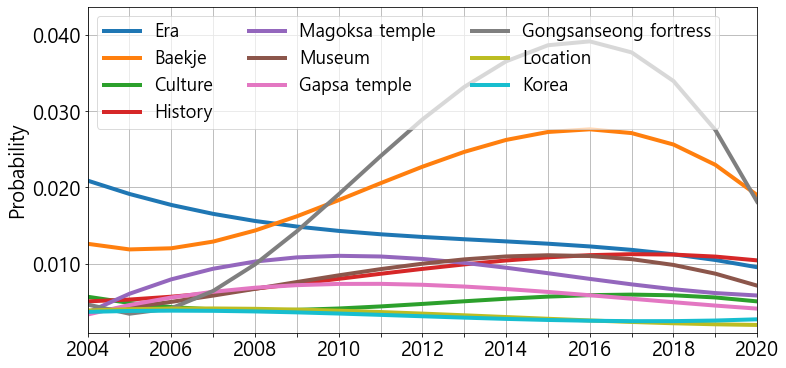

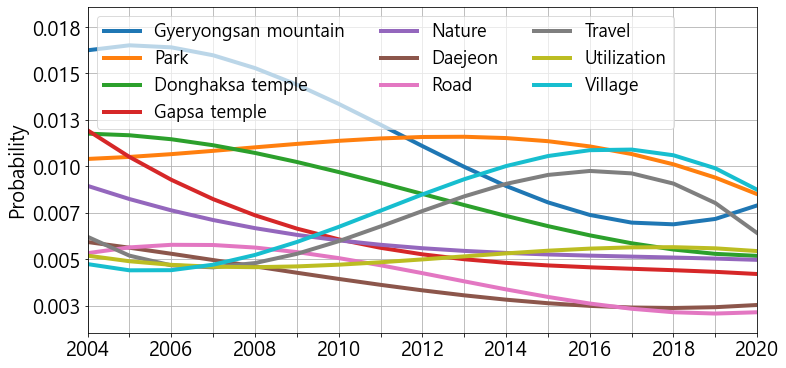

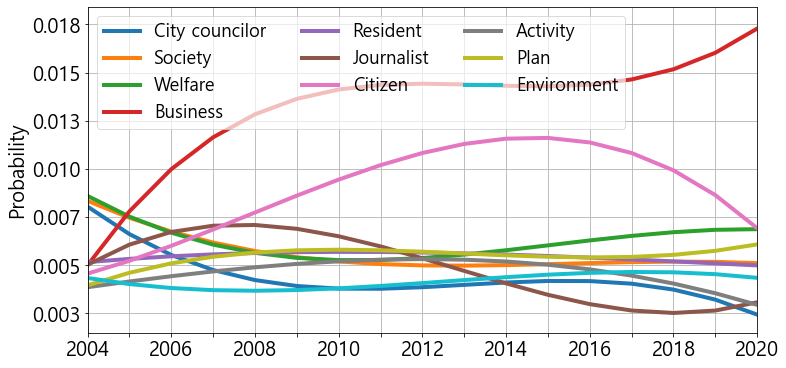

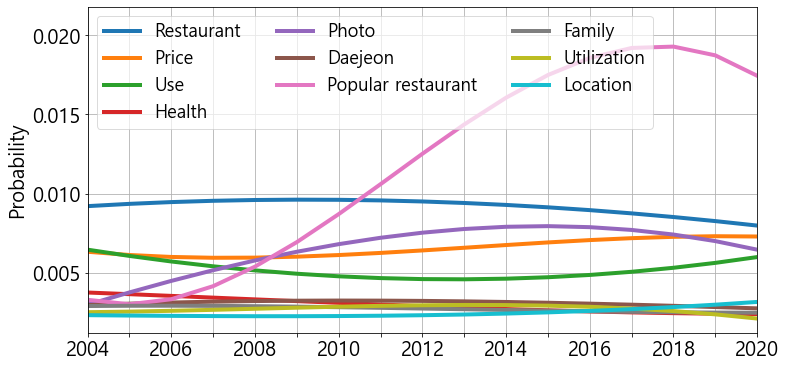

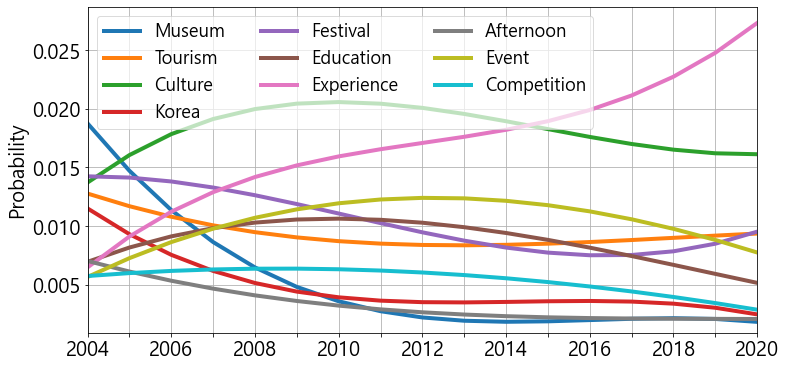

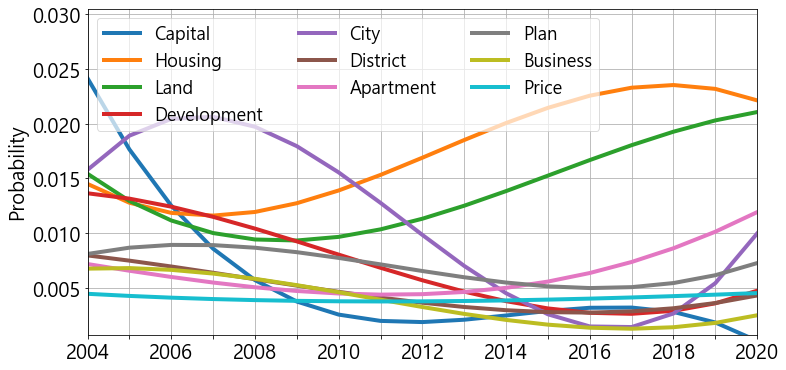

In [43]:
xlabel = ['2004', '', '2006','', '2008','', '2010','', '2012','', '2014','', '2016','', '2018','', '2020']

idx = 0
for i in range(n_topics):
    ylabel = word_list[i]
    
    length_list = [len(word_list[idx]) for idx in range(len(word_list))]
    
    x = word_score[idx : idx+length_list[i]]
    idx = idx + length_list[i]

    visualize(x, xlabel, ylabel, flag=True, bent=3, isSave=True,
              minlimit=0.001, maxlimit=0.001, order=i, filedir=image_path, filename="words" +str(i+1), fontsize=18)